In [1]:
# Imports
import scipy.io
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim
import os
import hashlib
import requests
from matplotlib import pyplot as plt
import tqdm as tqdm

In [2]:
# Variables for file and download URL
fname = "condsForSimJ2moMuscles.mat"  # The name of the file to be downloaded
url = "https://osf.io/wak7e/download" # URL from where the file will be downloaded
expected_md5 = "257d16c4d92759d615bf5cac75dd9a1f" # MD5 hash for verifying file integrity

# Check if the file already exists
if not os.path.isfile(fname):
    try:
        # Attempt to download the file
        r = requests.get(url) # Make a GET request to the specified URL
    except requests.ConnectionError:
        # Handle connection errors during the download
        print("!!! Failed to download data !!!")
    else:
        # No connection errors, proceed to check the response
        if r.status_code != requests.codes.ok:
            # Check if the HTTP response status code indicates a successful download
            print("!!! Failed to download data !!!")
        elif hashlib.md5(r.content).hexdigest() != expected_md5:
            # Verify the integrity of the downloaded file using MD5 checksum
            print("!!! Data download appears corrupted !!!")
        else:
            # If download is successful and data is not corrupted, save the file
            with open(fname, "wb") as fid:
                fid.write(r.content) # Write the downloaded content to a file

In [3]:
import numpy as np
import torch
import scipy.io

# Load the .mat file
data = scipy.io.loadmat('condsForSimJ2moMuscles.mat')

# Extract condsForSim struct
conds_for_sim = data['condsForSim']

# Initialize lists to store data for all conditions
go_envelope_all = []
plan_all = []
muscle_all = []

# Get the number of conditions (rows) and delay durations (columns)
num_conditions, num_delays = conds_for_sim.shape

# Loop through each condition and extract data
for i in range(num_conditions):  # 27 conditions
    go_envelope_condition = []
    plan_condition = []
    muscle_condition = []

    for j in range(num_delays):  # 8 delay durations
        condition = conds_for_sim[i, j]

        go_envelope = condition['goEnvelope']
        plan = condition['plan']
        muscle = condition['muscle']

        # Select only muscles 5 and 6 
        selected_muscle_data = muscle[:, [3, 4]]  # which show the nicest multiphasic activity

        go_envelope_condition.append(go_envelope)
        plan_condition.append(plan)
        muscle_condition.append(selected_muscle_data)

    # Convert lists of NumPy arrays to single NumPy arrays before conversion to tensors
    go_envelope_np = np.array(go_envelope_condition)
    plan_np = np.array(plan_condition)
    muscle_np = np.array(muscle_condition)

    # Convert the single NumPy arrays to PyTorch tensors
    go_envelope_all.append(torch.tensor(go_envelope_np, dtype=torch.float32))
    plan_all.append(torch.tensor(plan_np, dtype=torch.float32))
    muscle_all.append(torch.tensor(muscle_np, dtype=torch.float32))

# Stack data for all conditions
go_envelope_tensor = torch.stack(go_envelope_all)
plan_tensor = torch.stack(plan_all)
muscle_tensor = torch.stack(muscle_all)

# Print the shapes to confirm
print(f'Go Envelope Tensor: {go_envelope_tensor.shape}')
print(f'Plan Tensor: {plan_tensor.shape}')
print(f'Muscle Tensor: {muscle_tensor.shape}')

# Clean up
del data, conds_for_sim, go_envelope_all, plan_all, muscle_all
import gc
gc.collect()


Go Envelope Tensor: torch.Size([27, 8, 296, 1])
Plan Tensor: torch.Size([27, 8, 296, 15])
Muscle Tensor: torch.Size([27, 8, 296, 2])


0

shape of normalised inputs torch.Size([27, 8, 296, 16])


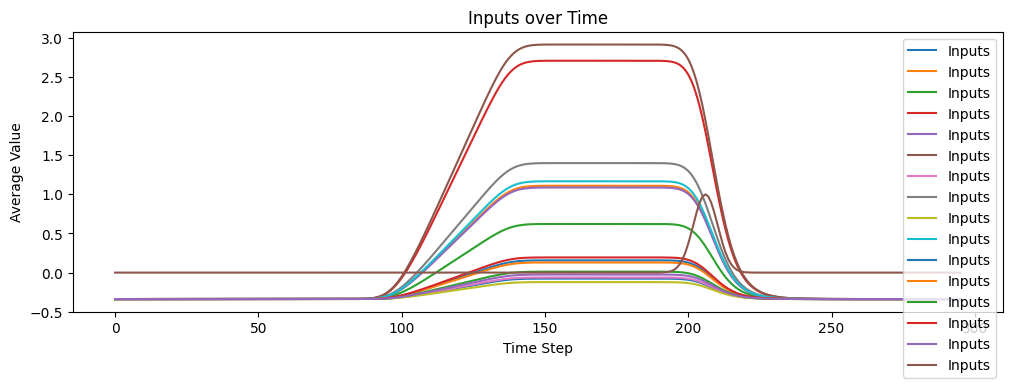

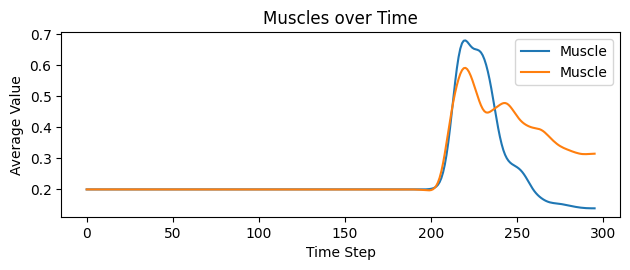

In [4]:
# Normalization and Standardization Function
def normalize_and_standardize(tensor):
    # Normalize
    min_val = tensor.min()
    max_val = tensor.max()
    tensor = (tensor - min_val) / (max_val - min_val)    
    # Standardize
    mean = tensor.mean()
    std = tensor.std()
    standardized_normalized_tensor = (tensor - mean) / std
    return standardized_normalized_tensor

plan_tensor = normalize_and_standardize(plan_tensor)

# Concatenate Plan and Go Envelope Tensors
normalised_inputs = torch.cat([plan_tensor, go_envelope_tensor], dim=3)  # Resulting shape: [27, 8, 296, 16]

print("shape of normalised inputs", normalised_inputs.shape)

# Averaging across conditions and delays
avg_inputs = normalised_inputs.mean(dim=[0, 1]).squeeze()
avg_output = muscle_tensor.mean(dim=[0, 1])

# For plan and muscle
# individual features for plotting 
feature_idx = 7 #max14
muscle_idx = 1 #max1

# Time steps
timesteps = np.arange(296)

# Plotting Go Envelope
plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
plt.plot(timesteps, avg_inputs, label='Inputs')
plt.title('Inputs over Time')
plt.xlabel('Time Step')
plt.ylabel('Average Value')
plt.legend()
plt.show()
# Plotting Muscle Feature
plt.subplot(2, 1, 2)
plt.plot(timesteps, avg_output, label=f'Muscle')
plt.title(f'Muscles over Time')
plt.xlabel('Time Step')
plt.ylabel('Average Value')
plt.legend()

plt.tight_layout()
plt.show()

In [5]:
class ComplicatedTimeseriesDataset(Dataset):
    def __init__(self, inputs, targets, delay_idx):
        """
        inputs: Tensor of shape [27, 8, 296, input_features]
        targets: Tensor of shape [27, 8, 296, output_features]
        delay_idx: Fixed index of the delay to be used
        """
        self.inputs = inputs[:, delay_idx]
        self.targets = targets[:, delay_idx]
        self.num_conditions = inputs.shape[0]

        print("Shape of inputs - ComplicatedRNN", self.inputs.shape)
        print("Shape of targets - ComplicatedRNN", self.targets.shape)

    def __len__(self):
        return self.num_conditions

    def __getitem__(self, idx):
        input_seq = self.inputs[idx]
        target_seq = self.targets[idx]
        return input_seq, target_seq

# Choose the delay index
fixed_delay_idx = 3

# Create the dataset with the fixed delay
complicated_dataset = ComplicatedTimeseriesDataset(normalised_inputs, muscle_tensor, fixed_delay_idx)

# Split the dataset
train_size = int(0.6 * len(complicated_dataset))
val_size = int(0.2 * len(complicated_dataset))
test_size = len(complicated_dataset) - train_size - val_size

complicated_train_dataset, complicated_val_dataset, complicated_test_dataset = random_split(complicated_dataset, [train_size, val_size, test_size])

# Create DataLoaders
batch_size = 1
complicated_train_loader = DataLoader(complicated_train_dataset, batch_size=batch_size, shuffle=True)
complicated_val_loader = DataLoader(complicated_val_dataset, batch_size=batch_size, shuffle=False)
complicated_test_loader = DataLoader(complicated_test_dataset, batch_size=batch_size, shuffle=False)


Shape of inputs - ComplicatedRNN torch.Size([27, 296, 16])
Shape of targets - ComplicatedRNN torch.Size([27, 296, 2])


In [6]:
# Flatten the first two dimensions (conditions and delays)
flattened_inputs = normalised_inputs.view(-1, *normalised_inputs.shape[2:])
flattened_targets = muscle_tensor.view(-1, *muscle_tensor.shape[2:])

class SimpleTimeseriesDataset(Dataset):
    def __init__(self, inputs, targets):
        self.inputs = inputs
        self.targets = targets
        
        print("Shape of inputs - SimpleRNN", self.inputs.shape)
        print("Shape of targets - SimpleRNN", self.targets.shape)

    def __len__(self):
        return self.inputs.shape[0]

    def __getitem__(self, idx):
        input_seq = self.inputs[idx]
        target_seq = self.targets[idx]
        return input_seq, target_seq

# Create the SimpleRNN dataset
simple_dataset = SimpleTimeseriesDataset(flattened_inputs, flattened_targets)

# Split the dataset
simple_train_size = int(0.6 * len(simple_dataset))
simple_val_size = int(0.2 * len(simple_dataset))
simple_test_size = len(simple_dataset) - simple_train_size - simple_val_size

simple_train_dataset, simple_val_dataset, simple_test_dataset = random_split(simple_dataset, [simple_train_size, simple_val_size, simple_test_size])

batch_size = 31

# Create DataLoaders
simple_train_loader = DataLoader(simple_train_dataset, batch_size=batch_size, shuffle=True)
simple_val_loader = DataLoader(simple_val_dataset, batch_size=batch_size, shuffle=False)
simple_test_loader = DataLoader(simple_test_dataset, batch_size=batch_size, shuffle=False)


Shape of inputs - SimpleRNN torch.Size([216, 296, 16])
Shape of targets - SimpleRNN torch.Size([216, 296, 2])


In [7]:
def validate_model(model, val_loader, criterion, device):
    model.eval()  # Set the model to evaluation mode
    total_val_loss = 0.0
    with torch.no_grad():  # Disable gradient computation
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            batch_size = inputs.size(0)
            h = model.init_hidden(batch_size).to(device)

            for t in range(inputs.shape[1]):
                # Capture any additional outputs in 'rest' 
                output, h, *rest = model(inputs[:, t, :], h)
            
            loss = criterion(output, targets[:, -1, :])
            total_val_loss += loss.item()

    avg_val_loss = total_val_loss / len(val_loader)
    return avg_val_loss

def test_model(model, test_loader, criterion, device):
    model.eval()  # Set the model to evaluation mode
    total_test_loss = 0.0
    with torch.no_grad():  # Disable gradient computation
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            batch_size = inputs.size(0)
            h = model.init_hidden(batch_size).to(device)

            for t in range(inputs.shape[1]):
                # Capture any additional outputs in 'rest' 
                output, h, *rest = model(inputs[:, t, :], h)
            
            loss = criterion(output, targets[:, -1, :])
            total_test_loss += loss.item()

    avg_test_loss = total_test_loss / len(test_loader)
    return avg_test_loss


Epoch 1, Training Loss: 0.1017117328941822
Epoch 1, Validation Loss: 0.0030747156124562025
Epoch 2, Training Loss: 0.08507688194513321
Epoch 2, Validation Loss: 0.0013484086957760155
Epoch 3, Training Loss: 0.08049638494849205
Epoch 3, Validation Loss: 0.0010342258028686047
Epoch 4, Training Loss: 0.07645765766501426
Epoch 4, Validation Loss: 0.0008182978199329227
Epoch 5, Training Loss: 0.07248166054487229
Epoch 5, Validation Loss: 0.000591066520428285
Epoch 6, Training Loss: 0.06895355582237243
Epoch 6, Validation Loss: 0.0005500855040736496
Epoch 7, Training Loss: 0.0659909762442112
Epoch 7, Validation Loss: 0.0006594049627892673
Epoch 8, Training Loss: 0.06350060924887657
Epoch 8, Validation Loss: 0.000423758800025098
Epoch 9, Training Loss: 0.061105364561080934
Epoch 9, Validation Loss: 0.00022920595802133903
Epoch 10, Training Loss: 0.05879762843251228
Epoch 10, Validation Loss: 0.00014106933667790145
Epoch 11, Training Loss: 0.056466877460479736
Epoch 11, Validation Loss: 0.0001

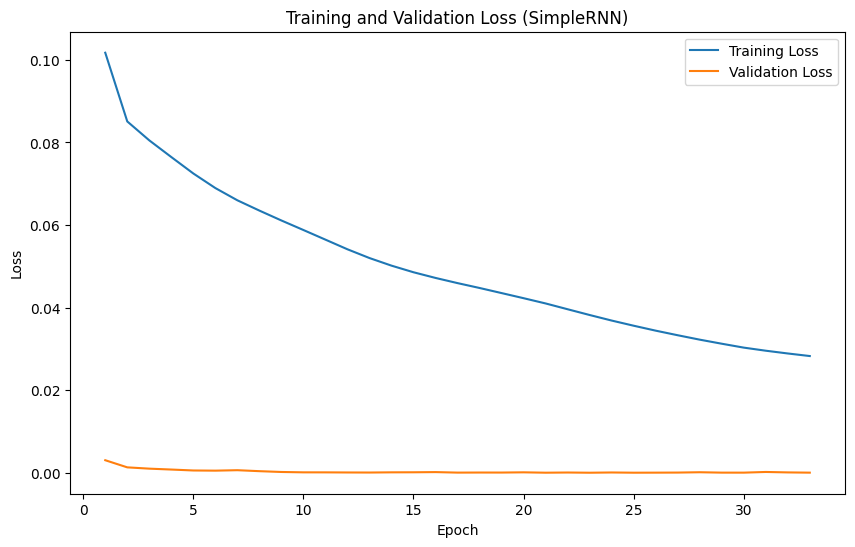

In [8]:
from torch.cuda.amp import autocast, GradScaler
from torch.autograd import profiler

# Define a custom Rectified Tanh activation function
def rectified_tanh(x):
    return torch.where(x > 0, torch.tanh(x), 0) # was torch.where(x > 0, x, torch.tanh(x))
def grad_rectified_tanh(x):
    return torch.where(x > 0, 1 - torch.tanh(x)**2, 0)
def grad_tanh(x):
    return 1 - torch.tanh(x)**2
    
class SimpleRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, g, h, tau=50):
        super(SimpleRNN, self).__init__()
        self.hidden_size = hidden_size
        self.tau = tau  # Time constant
        self.output_linear = nn.Linear(hidden_size, output_size)  

        # Weight initialization
        self.J = nn.Parameter(torch.randn(hidden_size, hidden_size) * (g / torch.sqrt(torch.tensor(hidden_size, dtype=torch.float))))
        self.B = nn.Parameter(torch.randn(hidden_size, input_size) * (h / torch.sqrt(torch.tensor(input_size, dtype=torch.float)))) 
        self.bx = nn.Parameter(torch.zeros(hidden_size))

        # Nonlinearity
        self.nonlinearity = rectified_tanh 
         
    def forward(self, x, hidden):
        hidden_prev = hidden.clone()
        timestep = self.tau / 10  # Timestep for Euler integration    
        # Update hidden state
        firing_rate = self.nonlinearity(hidden)        
        hidden_update = torch.matmul(self.J, firing_rate.transpose(0, 1)) 
        input_update = torch.matmul(self.B, x.transpose(0, 1))        
        new_hidden = hidden_update + input_update + self.bx.unsqueeze(1)
        new_hidden = new_hidden.transpose(0, 1)    
        # Euler integration for continuous-time update
        hidden = hidden + (timestep / self.tau) * (-hidden_prev + new_hidden)    
        # Output calculation
        output = self.output_linear(firing_rate)    
        # Regularization terms
        firing_rate_reg = hidden.pow(2).sum()
        dynamic_reg = torch.linalg.norm(torch.matmul(self.J, grad_rectified_tanh(hidden.transpose(0, 1))), ord='fro', dim=(-2, -1)).sum()
 
        return output, hidden, firing_rate_reg, dynamic_reg

    def init_hidden(self, batch_size):
        # Initialize hidden state with batch dimension
        return torch.zeros(batch_size, self.hidden_size)

def compute_l2_regularization(parameters, alpha):
    l2_reg = sum(p.pow(2.0).sum() for p in parameters)
    return alpha * l2_reg

# Hyperparameters
input_size = 16 # Features + Go Cue
hidden_size = 150
output_size = 2  # Number of muscles
g = 1.5  # g value
h_val = 1.0  # h value

# Hyperparameters for regularization
alpha = 1e-4  
beta = 0.03
gamma = 1e-4

# Training Loop
num_epochs = 100
epoch_losses = [] 
val_losses = []

patience = 10  # Number of epochs to wait for improvement
best_val_loss = float('inf')
epochs_no_improve = 0
early_stop = False

# get available device
if torch.backends.mps.is_available():
    device = torch.device('mps')
elif torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# Model instantiation
model = SimpleRNN(input_size, hidden_size, output_size, g, h_val)
model.to(device)

# Loss Function and Optimizer
criterion = nn.MSELoss()  # MSE Loss for regression tasks
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0) ### WD=0. Note: Paper uses Hessian-Free optimizer
scaler = GradScaler()

for epoch in range(num_epochs):
    running_loss = 0.0
    model.train()  # Set the model to training mode

    # Initialize hidden states 
    hidden_states_for_plot = []

    for inputs, targets in simple_train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        batch_size = inputs.size(0)
        h = model.init_hidden(batch_size).to(device)
        optimizer.zero_grad() 

        total_firing_rate_reg = 0
        total_dynamic_reg = 0

        with autocast():  # Enable automatic mixed precision
            for t in range(inputs.shape[1]):
                output, h, firing_rate_reg, dynamic_reg = model(inputs[:, t, :], h)
                hidden_states_for_plot.append(h.detach().cpu().numpy())
                total_firing_rate_reg += firing_rate_reg
                total_dynamic_reg += dynamic_reg

            # Compute loss and regularization terms
            loss = criterion(output, targets[:, -1, :])
            l2_reg = compute_l2_regularization(model.parameters(), alpha)
            rfr_reg = beta * total_firing_rate_reg / inputs.shape[1] / hidden_size / num_conditions
            rj_reg = gamma * total_dynamic_reg / inputs.shape[1] / num_conditions
            total_loss = loss + l2_reg + rfr_reg + rj_reg

        scaler.scale(total_loss).backward()  # Scale loss and perform backward pass
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)
        scaler.step(optimizer)  # Update optimizer
        scaler.update()  # Update scaler

        running_loss += total_loss.item()

    avg_loss = running_loss / len(simple_train_loader)
    epoch_losses.append(avg_loss)
    print(f'Epoch {epoch + 1}, Training Loss: {avg_loss}')

    # Validation phase after completing the training for one epoch
    val_loss = validate_model(model, simple_val_loader, criterion, device)
    val_losses.append(val_loss)
    print(f'Epoch {epoch + 1}, Validation Loss: {val_loss}')

    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= patience:
        print("Early stopping triggered at epoch", epoch + 1)
        early_stop = True
        break

    # Clear CUDA cache if needed
    if device.type == 'cuda':
        torch.cuda.empty_cache()

# Check if training was stopped by early stopping
if early_stop:
    print('Training stopped due to early stopping at epoch', epoch + 1)
else:
    print('Finished Training')
# Testing phase
test_loss = test_model(model, simple_test_loader, criterion, device)
print(f'Test Loss: {test_loss}')

# Clear cache after training
if device.type == 'cuda':
    torch.cuda.empty_cache()
    
# Determine the number of epochs for which you have loss data
actual_num_epochs = len(epoch_losses)  # This will be less than num_epochs if early stopping was triggered

plt.figure(figsize=(10, 6))
plt.plot(range(1, actual_num_epochs + 1), epoch_losses, label='Training Loss')
plt.plot(range(1, actual_num_epochs + 1), val_losses, label='Validation Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss (SimpleRNN)')
plt.legend()
plt.show()


Epoch 1, Training Loss: 0.16675743694941048
Epoch 1, Validation Loss: 0.0045319700613617895
Epoch 2, Training Loss: 0.018752653857518453
Epoch 2, Validation Loss: 0.023899818933568896
Epoch 3, Training Loss: 0.00771789762438857
Epoch 3, Validation Loss: 0.010180277959443628
Epoch 4, Training Loss: 0.004373468338599196
Epoch 4, Validation Loss: 0.004417219361494062
Epoch 5, Training Loss: 0.003987540980688209
Epoch 5, Validation Loss: 0.0023659124097321184
Epoch 6, Training Loss: 0.0019925830338252126
Epoch 6, Validation Loss: 0.0015735891181975603
Epoch 7, Training Loss: 0.001540978822845318
Epoch 7, Validation Loss: 0.0027600952424108984
Epoch 8, Training Loss: 0.000693157171212988
Epoch 8, Validation Loss: 0.001587968108651694
Epoch 9, Training Loss: 0.0015739722930447897
Epoch 9, Validation Loss: 0.002012995834229514
Epoch 10, Training Loss: 0.001071063666131522
Epoch 10, Validation Loss: 0.0011573830561246723
Epoch 11, Training Loss: 0.0009043489344549016
Epoch 11, Validation Loss:

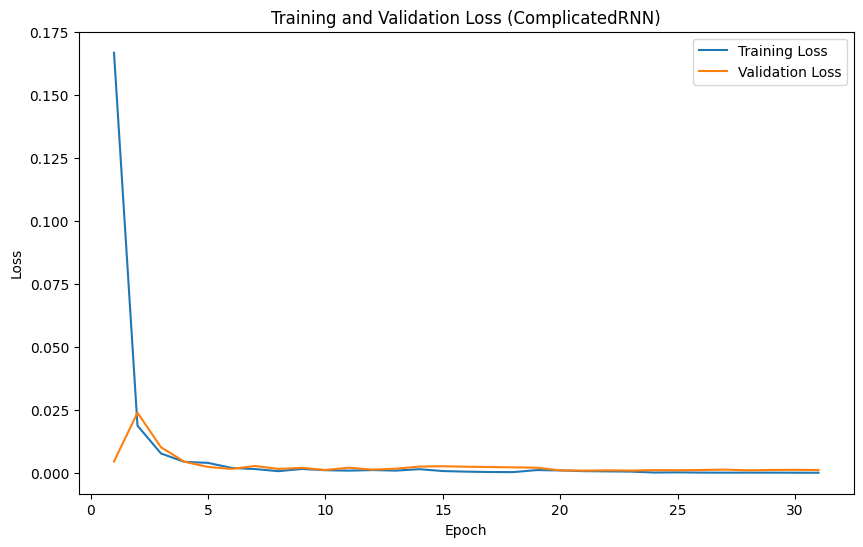

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.cuda.amp import GradScaler
from torch.cuda.amp import autocast

# Define a custom Rectified Tanh activation function
def rectified_tanh(x):
    return torch.where(x > 0, torch.tanh(x), 0) # was torch.where(x > 0, x, torch.tanh(x))
def grad_rectified_tanh(x):
    return torch.where(x > 0, 1 - torch.tanh(x)**2, 0)
def grad_tanh(x):
    return 1 - torch.tanh(x)**2

# ComplicatedRNN class
class ComplicatedRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, g, h, tau=50):
        super(ComplicatedRNN, self).__init__()
        self.hidden_size = hidden_size
        self.tau = tau
        self.output_linear = nn.Linear(hidden_size, output_size)

        # Weight initialization (unchanged)
        self.J = nn.Parameter(torch.randn(hidden_size, hidden_size) * (g / torch.sqrt(torch.tensor(hidden_size, dtype=torch.float))))
        self.B = nn.Parameter(torch.randn(hidden_size, input_size) * (h / torch.sqrt(torch.tensor(input_size, dtype=torch.float)))) 
        self.bx = nn.Parameter(torch.zeros(hidden_size))

        # Nonlinearity (unchanged)
        self.nonlinearity = rectified_tanh 
        
    def forward(self, x, hidden):
        # Forward pass logic (same as SimpleRNN but without regularization terms)
        hidden_prev = hidden.clone()
        timestep = self.tau / 10
        #Update hidden state
        firing_rate = self.nonlinearity(hidden)        
        hidden_update = torch.matmul(self.J, firing_rate.transpose(0, 1))
        input_update = torch.matmul(self.B, x.transpose(0, 1))     
        new_hidden = hidden_update + input_update + self.bx.unsqueeze(1)
        new_hidden = new_hidden.transpose(0, 1)
        # Euler integration for continuous-time update
        hidden = hidden + (timestep / self.tau) * (-hidden_prev + new_hidden)
        output = self.output_linear(firing_rate)
        
        return output, hidden
        
    def init_hidden(self, batch_size):
        return torch.zeros(batch_size, self.hidden_size)

# Training loop
# Hyperparameters
input_size = 16
hidden_size = 150
output_size = 2  # Number of muscles
g = 4  # g value
h_val = 1.0  # h value

# Training Loop
num_epochs = 100
epoch_losses = [] 
val_losses = []

patience = 10  # Number of epochs to wait for improvement
best_val_loss = float('inf')
epochs_no_improve = 0
early_stop = False

# get available device
if torch.backends.mps.is_available():
    device = torch.device('mps')
elif torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# Model instantiation
complicated_model = ComplicatedRNN(input_size, hidden_size, output_size, g, h_val)
complicated_model.to(device)

# Loss function and optimizer (no weight decay)
criterion = nn.MSELoss()
optimizer = optim.Adam(complicated_model.parameters(), lr=0.001, weight_decay=0)
scaler = GradScaler()

# Training loop 
for epoch in range(num_epochs):
    running_loss = 0.0
    hidden_states_for_plot_cm = []

    complicated_model.train()  # Set the model to training mode
    for inputs, targets in complicated_train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        batch_size = inputs.size(0)
        h = complicated_model.init_hidden(batch_size).to(device)
        optimizer.zero_grad()

        with autocast():  # Apply automatic mixed precision
            for t in range(inputs.shape[1]):
                output, h = complicated_model(inputs[:, t, :], h)
                hidden_states_for_plot_cm.append(h.detach().cpu().numpy())

            loss = criterion(output, targets[:, -1, :])

        scaler.scale(loss).backward()  # Scale loss for backward pass
        scaler.step(optimizer)  # Update optimizer with scaled gradients
        scaler.update()  # Update the scaler

        running_loss += loss.item()

    avg_loss = running_loss / len(complicated_train_loader)
    epoch_losses.append(avg_loss)
    print(f'Epoch {epoch + 1}, Training Loss: {avg_loss}')

    # Validation phase after completing the training for one epoch
    val_loss = validate_model(complicated_model, complicated_val_loader, criterion, device)
    val_losses.append(val_loss)
    print(f'Epoch {epoch + 1}, Validation Loss: {val_loss}')

    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= patience:
        print("Early stopping triggered at epoch", epoch + 1)
        early_stop = True
        break

    # Clear CUDA cache if needed
    if device.type == 'cuda':
        torch.cuda.empty_cache()

# Check if training was stopped by early stopping
if early_stop:
    print('Training stopped due to early stopping at epoch', epoch + 1)
else:
    print('Finished Training')
# Testing phase
test_loss = test_model(complicated_model, complicated_test_loader, criterion, device)
print(f'Test Loss: {test_loss}')

# Clear cache after training
if device.type == 'cuda':
    torch.cuda.empty_cache()
    
# Determine the number of epochs for which you have loss data
actual_num_epochs = len(epoch_losses)  # This will be less than num_epochs if early stopping was triggered

plt.figure(figsize=(10, 6))
plt.plot(range(1, actual_num_epochs + 1), epoch_losses, label='Training Loss')
plt.plot(range(1, actual_num_epochs + 1), val_losses, label='Validation Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss (ComplicatedRNN)')
plt.legend()
plt.show()

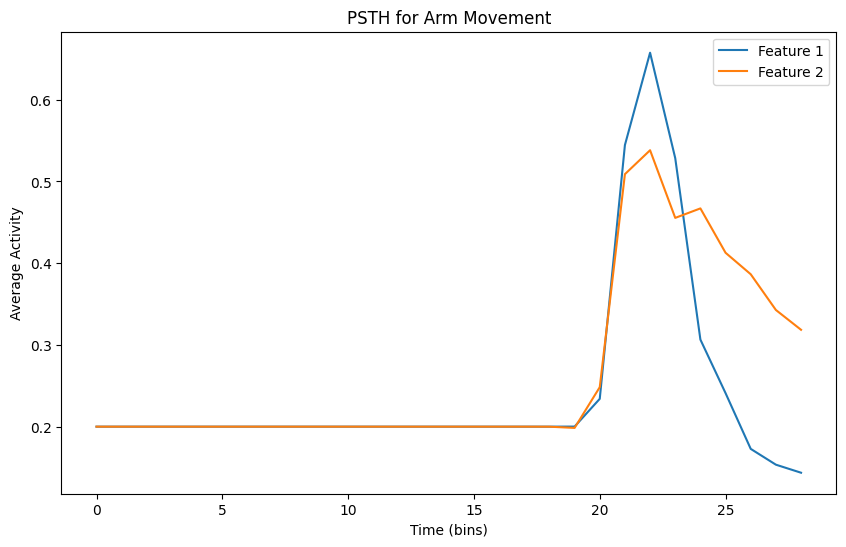

In [10]:
import matplotlib.pyplot as plt
import torch

def plot_psth(data, title, bin_size=10):
    """
    Plot Peri-Stimulus Time Histogram (PSTH) for given data.
    :param data: a tensor containing the neural data of shape [conditions, delays, time, features]
    :param title: a string for the plot title
    :param bin_size: size of time bins for averaging
    """
    # Averaging neural activity across conditions, delays for each time bin
    mean_data = data.mean(dim=(0, 1))  # Mean across conditions and delays

    # Number of bins
    n_bins = mean_data.shape[0] // bin_size

    # Prepare the data for plotting
    binned_data = mean_data[:n_bins*bin_size].unfold(0, bin_size, bin_size).mean(dim=2)

    # Plot
    plt.figure(figsize=(10, 6))
    for i in range(binned_data.shape[1]):  # Iterate over each feature/channel
        plt.plot(binned_data[:, i], label=f'Feature {i+1}')
    plt.xlabel('Time (bins)')
    plt.ylabel('Average Activity')
    plt.title(title)
    plt.legend()
    plt.show()

plot_psth(muscle_tensor, "PSTH for Arm Movement")


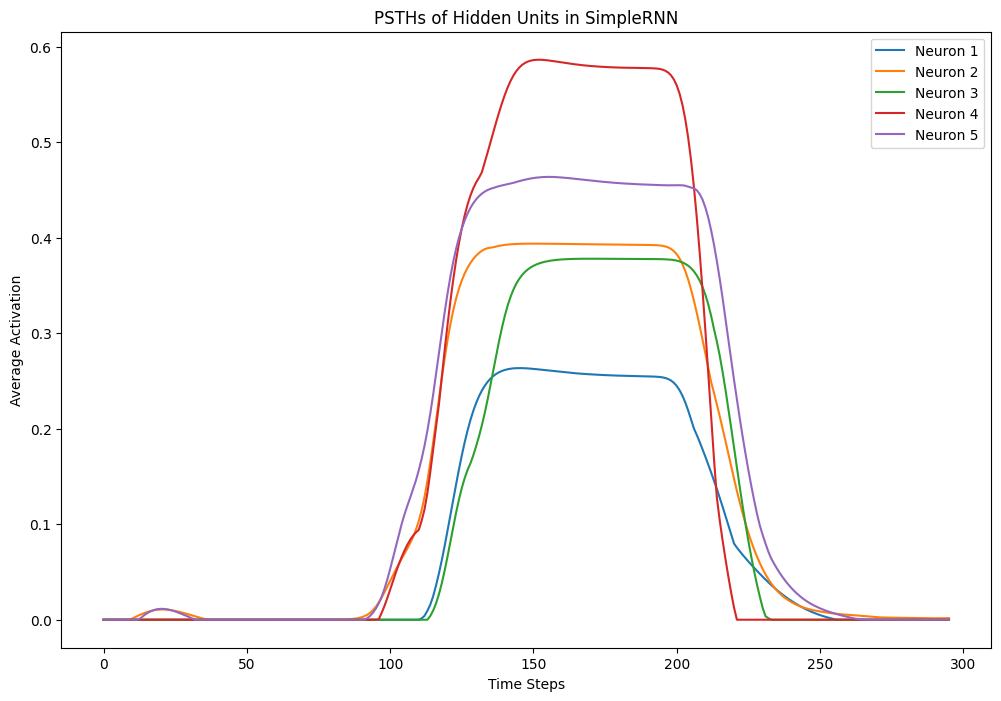

In [11]:
import numpy as np
import matplotlib.pyplot as plt

# Slicing to take only the last 296 timesteps
last_hidden_states = hidden_states_for_plot[-296:]

# Apply the nonlinearity to each hidden state before averaging
rectified_tanh = lambda x: np.where(x > 0, np.tanh(x), 0)
hidden_states = rectified_tanh(np.array(last_hidden_states))

# Calculate the mean across all batches for each time step
mean_activations = np.mean(hidden_states, axis=1)

# Plot the PSTHs for the first few neurons
neurons_to_plot = 5  
time_steps = mean_activations.shape[0]
plt.figure(figsize=(12, 8))

for i in range(min(neurons_to_plot, hidden_states.shape[2])):
    plt.plot(range(time_steps), mean_activations[:, i], label=f'Neuron {i+1}')

plt.xlabel('Time Steps')
plt.ylabel('Average Activation')
plt.title('PSTHs of Hidden Units in SimpleRNN')
plt.legend()
plt.show()


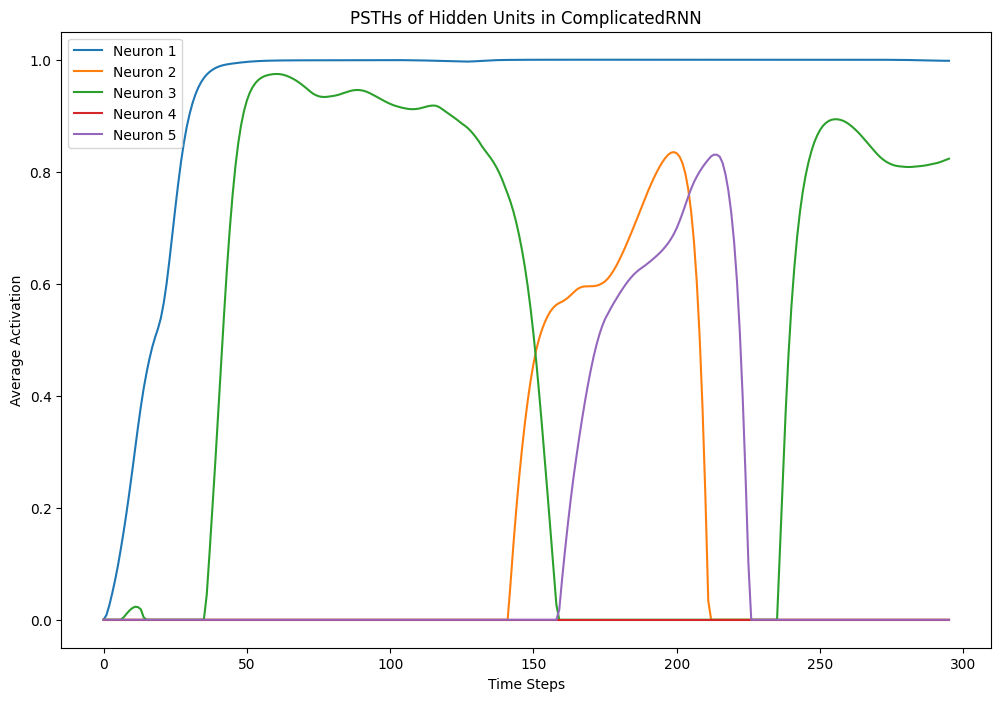

In [12]:
import numpy as np
import matplotlib.pyplot as plt

# Slicing to take only the last 296 timesteps
last_hidden_states = hidden_states_for_plot_cm[-296:]

# Apply the nonlinearity to each hidden state before averaging
rectified_tanh = lambda x: np.where(x > 0, np.tanh(x), 0)
hidden_states = rectified_tanh(np.array(last_hidden_states))

# Calculate the mean across all batches for each time step
mean_activations = np.mean(hidden_states, axis=1)

# Plot the PSTHs for the first few neurons
neurons_to_plot = 5  
time_steps = mean_activations.shape[0]
plt.figure(figsize=(12, 8))

for i in range(min(neurons_to_plot, hidden_states.shape[2])):
    plt.plot(range(time_steps), mean_activations[:, i], label=f'Neuron {i+1}')

plt.xlabel('Time Steps')
plt.ylabel('Average Activation')
plt.title('PSTHs of Hidden Units in ComplicatedRNN')
plt.legend()
plt.show()


In [13]:
import torch
import numpy as np
import matplotlib.pyplot as plt

def perturb_inputs(model, inputs, perturbation_strength):
    # Perturb the inputs by adding random noise scaled by the perturbation strength and input strength
    input_strength = torch.norm(inputs, p=2, dim=-1, keepdim=True)  # Calculate the L2 norm of inputs
    noise = torch.randn_like(inputs) * perturbation_strength * input_strength  # Scale noise by input strength
    perturbed_inputs = inputs + noise
    return perturbed_inputs

def compute_loss(model, inputs, targets, criterion, device):
    batch_size = inputs.size(0)
    h = model.init_hidden(batch_size).to(device)  # Initialize hidden state
    losses = []
    for t in range(inputs.shape[1]):  # Iterate over time steps
        model_output = model(inputs[:, t, :], h)
        output, h, *rest = model_output[:2]
        loss = criterion(output, targets[:, t])  # Assume targets is a sequence of same length as inputs
        losses.append(loss)
    mean_loss = torch.mean(torch.stack(losses)).item()
    return mean_loss

def test_perturbed_inputs(model, perturbation_strengths, test_loader, criterion, device):
    model.eval()  # Set the model to evaluation mode
    perturbation_results = []

    for strength in perturbation_strengths:
        all_errors = []  # Store all errors for each perturbation strength to compute mean and s.d.
        print(f"Testing perturbation strength {strength}")
        for iteration in range(50):  # Repeat the procedure 50 times
            batch_errors = []  # Store errors for each batch
            print(f" Iteration {iteration+1}/50")
            
            for inputs, targets in test_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                # Compute error for original inputs
                original_loss = compute_loss(model, inputs, targets, criterion, device)
                # Compute error for perturbed inputs
                perturbed_inputs = perturb_inputs(model, inputs, strength)
                perturbed_loss = compute_loss(model, perturbed_inputs, targets, criterion, device)
                
                # Store the normalized error difference
                error_diff = abs(perturbed_loss - original_loss) / original_loss * 100  # Normalize as percentage
                error_diff = min(error_diff, 100)  # Truncate at 100%
                batch_errors.append(error_diff)
            
            all_errors.extend(batch_errors)
        
        mean_error = np.mean(all_errors)
        std_error = np.std(all_errors)
        perturbation_results.append((mean_error, std_error))
        print(f"Completed testing for perturbation strength {strength}. Mean error: {mean_error:.2f}%, Std. dev.: {std_error:.2f}%\n")
    
    return perturbation_results

perturbation_strengths = [0.0001, 0.001, 0.01, 0.1, 1]
results_complex = test_perturbed_inputs(complicated_model, perturbation_strengths, complicated_train_loader, criterion, device)
results_simple = test_perturbed_inputs(model, perturbation_strengths, simple_train_loader, criterion, device)

Testing perturbation strength 0.0001
 Iteration 1/50
 Iteration 2/50
 Iteration 3/50
 Iteration 4/50
 Iteration 5/50
 Iteration 6/50
 Iteration 7/50
 Iteration 8/50
 Iteration 9/50
 Iteration 10/50
 Iteration 11/50
 Iteration 12/50
 Iteration 13/50
 Iteration 14/50
 Iteration 15/50
 Iteration 16/50
 Iteration 17/50
 Iteration 18/50
 Iteration 19/50
 Iteration 20/50
 Iteration 21/50
 Iteration 22/50
 Iteration 23/50
 Iteration 24/50
 Iteration 25/50
 Iteration 26/50
 Iteration 27/50
 Iteration 28/50
 Iteration 29/50
 Iteration 30/50
 Iteration 31/50
 Iteration 32/50
 Iteration 33/50
 Iteration 34/50
 Iteration 35/50
 Iteration 36/50
 Iteration 37/50
 Iteration 38/50
 Iteration 39/50
 Iteration 40/50
 Iteration 41/50
 Iteration 42/50
 Iteration 43/50
 Iteration 44/50
 Iteration 45/50
 Iteration 46/50
 Iteration 47/50
 Iteration 48/50
 Iteration 49/50
 Iteration 50/50
Completed testing for perturbation strength 0.0001. Mean error: 0.00%, Std. dev.: 0.00%

Testing perturbation strength 0.0

(0.0007055484888813958, 0.007187491561248437, 0.07185145479115312, 0.8351780683173775, 30.788842621891753)


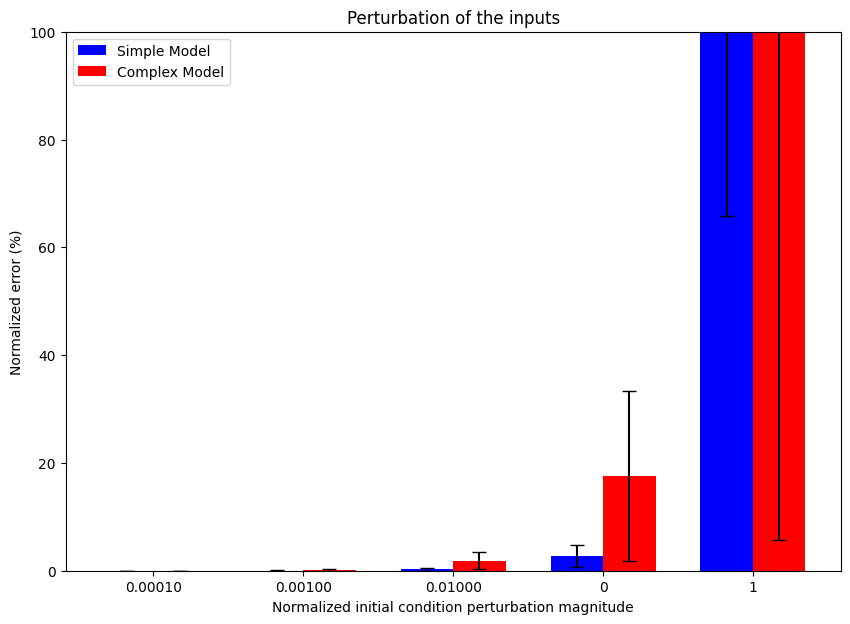

In [26]:
mean_errors_simple, std_errors_simple = zip(*results_simple)
mean_errors_complex, std_errors_complex = zip(*results_complex)

print(mean_errors_simple)

# Find the maximum mean error for both models
max_error_simple = max(mean_errors_simple)
max_error_complex = max(mean_errors_complex)

# Normalize mean errors by their maximum values and multiply by 100
normalized_mean_errors_simple = [(x / max_error_simple) * 100 for x in mean_errors_simple]
normalized_mean_errors_complex = [(x / max_error_complex) * 100 for x in mean_errors_complex]

# Normalize standard deviations by the same factor as their corresponding means
normalized_std_errors_simple = [(y / max_error_simple) * 100 for y in std_errors_simple]
normalized_std_errors_complex = [(y / max_error_complex) * 100 for y in std_errors_complex]

# Convert perturbation strengths to numeric values if necessary (e.g., from strings)
perturbation_strengths = [0.0001, 0.001, 0.01, 0.1, 1]

# Plotting
plt.figure(figsize=(10, 7))

# Width of a bar
bar_width = 0.35

# Positions of the left bar-boundaries
bar_positions = np.arange(len(perturbation_strengths))

# Bar plot for the simple model
plt.bar(bar_positions - bar_width/2, normalized_mean_errors_simple, width=bar_width, color='blue', yerr=normalized_std_errors_simple, capsize=5, label='Simple Model')

# Bar plot for the complex model
plt.bar(bar_positions + bar_width/2, normalized_mean_errors_complex, width=bar_width, color='red', yerr=normalized_std_errors_complex, capsize=5, label='Complex Model')

# Adding labels, title, and legend
plt.xlabel('Normalized initial condition perturbation magnitude')
plt.ylabel('Normalized error (%)')
plt.title('Perturbation of the inputs')
plt.xticks(bar_positions, [f"{x:.5f}" if x < 0.1 else f"{int(x)}" for x in perturbation_strengths])
plt.legend()

# Set y-axis to display up to 100%
plt.ylim(0, 100)

plt.show()

In [17]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from torch import nn, optim
from torch.utils.data import DataLoader

def calculate_mean_absolute_strength(model):
    # Calculate the mean absolute connection strength of the recurrent weight matrix
    return torch.mean(torch.abs(model.J)).item()

def perturb_recurrent_weights(model, mean_strength, perturbation_percentage):
    # Perturb the recurrent weight matrix J according to a normalized percentage of the mean absolute strength
    perturbation_strength = mean_strength * perturbation_percentage
    with torch.no_grad():
        noise = torch.randn_like(model.J) * perturbation_strength
        perturbed_weights = model.J + noise
        return perturbed_weights

def test_perturbed_structure(model, perturbation_percentages, test_loader, criterion, device):
    model.eval()  # Set the model to evaluation mode
    mean_strength = calculate_mean_absolute_strength(model)
    perturbation_errors = []
    perturbation_std_devs = []  # Store standard deviations for error bars
    original_weights = model.J.data.clone()  # Save the original weights

    for percentage in perturbation_percentages:
        multiple_perturbations_error = []
        print(f"Testing perturbation percentage {percentage:.4f}")
        
        for perturbation in range(50):  # Perturb 50 times for each strength
            batch_errors = []
            perturbed_weights = perturb_recurrent_weights(model, mean_strength, percentage)
            model.J.data = perturbed_weights.data
            print(f" Perturbation {perturbation+1}/50")

            for inputs, targets in test_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                batch_size = inputs.size(0)
                h = model.init_hidden(batch_size).to(device)
                
                for t in range(inputs.shape[1]):
                    model_output = model(inputs[:, t, :], h)
                    output, h = model_output[:2]  # Adjust based on model output
                
                loss = criterion(output, targets[:, -1, :]).item()
                batch_errors.append(loss)
            
            model.J.data = original_weights.data
            multiple_perturbations_error.append(np.mean(batch_errors))
        
        mean_error = np.mean(multiple_perturbations_error)  # Average over the 50 perturbations
        std_dev_error = np.std(multiple_perturbations_error)  # Standard deviation for error bars
        perturbation_errors.append(mean_error)
        perturbation_std_devs.append(std_dev_error)
        print(f"Completed testing for perturbation percentage {percentage:.4f}. Mean error: {mean_error:.4f}, Std. dev.: {std_dev_error:.4f}\n")
    
    return perturbation_errors, perturbation_std_devs

# Define perturbation strengths as percentages
perturbation_percentages = [0.0001, 0.001, 0.01, 0.1, 1]

# Function calls for simple and complex models
simple_model_errors_2, simple_model_std_devs_2 = test_perturbed_structure(model, perturbation_percentages, simple_train_loader, criterion, device)
complex_model_errors_2, complex_model_std_devs_2 = test_perturbed_structure(complicated_model, perturbation_percentages, complicated_train_loader, criterion, device)


Testing perturbation percentage 0.0001
 Perturbation 1/50
 Perturbation 2/50
 Perturbation 3/50
 Perturbation 4/50
 Perturbation 5/50
 Perturbation 6/50
 Perturbation 7/50
 Perturbation 8/50
 Perturbation 9/50
 Perturbation 10/50
 Perturbation 11/50
 Perturbation 12/50
 Perturbation 13/50
 Perturbation 14/50
 Perturbation 15/50
 Perturbation 16/50
 Perturbation 17/50
 Perturbation 18/50
 Perturbation 19/50
 Perturbation 20/50
 Perturbation 21/50
 Perturbation 22/50
 Perturbation 23/50
 Perturbation 24/50
 Perturbation 25/50
 Perturbation 26/50
 Perturbation 27/50
 Perturbation 28/50
 Perturbation 29/50
 Perturbation 30/50
 Perturbation 31/50
 Perturbation 32/50
 Perturbation 33/50
 Perturbation 34/50
 Perturbation 35/50
 Perturbation 36/50
 Perturbation 37/50
 Perturbation 38/50
 Perturbation 39/50
 Perturbation 40/50
 Perturbation 41/50
 Perturbation 42/50
 Perturbation 43/50
 Perturbation 44/50
 Perturbation 45/50
 Perturbation 46/50
 Perturbation 47/50
 Perturbation 48/50
 Perturbat

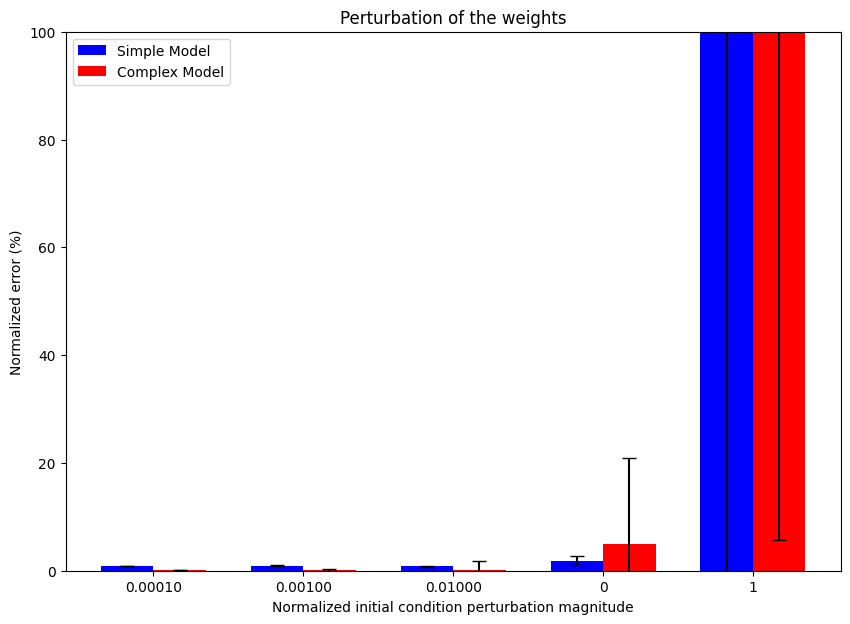

In [30]:
simple_model_errors_2 = tuple(simple_model_errors_2)
simple_model_std_devs_2 = tuple(simple_model_std_devs_2)
complex_model_errors_2 = tuple(complex_model_errors_2)
complex_model_std_devs_2 = tuple(complex_model_std_devs_2)

# Find the maximum mean error for both models
max_error_simple_2 = max(simple_model_errors_2)
max_error_complex_2 = max(complex_model_errors_2)

# Normalize mean errors by their maximum values and multiply by 100
normalized_mean_errors_simple_2 = [(x / max_error_simple_2) * 100 for x in simple_model_errors_2]
normalized_mean_errors_complex_2 = [(x / max_error_complex_2) * 100 for x in complex_model_errors_2]

# Normalize standard deviations by the same factor as their corresponding means
normalized_std_errors_simple_2 = [(y / max_error_simple_2) * 100 for y in simple_model_std_devs_2]
normalized_std_errors_complex_2 = [(y / max_error_complex_2) * 100 for y in complex_model_std_devs_2]

# Convert perturbation strengths to numeric values if necessary (e.g., from strings)
perturbation_strengths = [0.0001, 0.001, 0.01, 0.1, 1]

# Plotting
plt.figure(figsize=(10, 7))

# Width of a bar
bar_width = 0.35

# Positions of the left bar-boundaries
bar_positions = np.arange(len(perturbation_strengths))

# Bar plot for the simple model
plt.bar(bar_positions - bar_width/2, normalized_mean_errors_simple_2, width=bar_width, color='blue', yerr=normalized_std_errors_simple_2, capsize=5, label='Simple Model')

# Bar plot for the complex model
plt.bar(bar_positions + bar_width/2, normalized_mean_errors_complex_2, width=bar_width, color='red', yerr=normalized_std_errors_complex, capsize=5, label='Complex Model')

# Adding labels, title, and legend
plt.xlabel('Normalized initial condition perturbation magnitude')
plt.ylabel('Normalized error (%)')
plt.title('Perturbation of the weights')
plt.xticks(bar_positions, [f"{x:.5f}" if x < 0.1 else f"{int(x)}" for x in perturbation_strengths])
plt.legend()

# Set y-axis to display up to 100%
plt.ylim(0, 100)

plt.show()